# Exercício em Python - Tema 11 - Inteligência Artificial

Este exercício tem por objetivo utilizar algumas técnicas de Aprendizagem de Maquina a partir da base de dados do CABra, contendo 735 bacias hidrográficas com os valores de precipitações e vazões diários de outubro de 1980 a setembro de 2010 (30 anos hidrológicos). Para quantificar tais vazões pelo método, são usados dados de precipitação e temperatura médias das bacias, contidas na própria base de dados do CABra.

Vamos aqui aplicar o método de Grunsky para a Bacia 1. A análise de tendências passa pelas escalas anual e mensal, comparando-se os valores previstos com os observados.

##1. Importação de bibliotecas.



In [ ]:
import pathlib
import pandas as pd
import numpy as np
import io
import requests
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

##2. Importação dos dados do CABra

In [ ]:
#Escolha da bacia e base de dados (no caso, "ensemble")
bacia1 = "1"
base1 = "ens"
base2 = "ENS"

url = ("https://raw.githubusercontent.com/brunokenmarchezepe/CABra_exercicios/main/CABRA_dataset/CABra_climate_daily_series/" + base1 + "/CABra_" + bacia1 + "_climate_" + base2 + ".txt")

bacia_df = requests.get(url).content
bacia_df = pd.read_csv(io.StringIO(bacia_df.decode('utf-8', errors = 'ignore')),
                 skiprows = 13,
                 delimiter='\t')

bacia_df.columns = ['Year', 'Month', 'Day', 'p', 'tmin', 'tmax', 'rh', 'wnd', 'srad', 'et', 'pet_pm','pet_pt', 'pet_hg']

#Importação de dados de vazão observados
url = ("https://raw.githubusercontent.com/brunokenmarchezepe/CABra_exercicios/main/CABRA_dataset/CABra_daily_streamflow" + "/CABra_" + bacia1 + "_streamflow.txt")

bacia_df_streamflow = requests.get(url).content
bacia_df_streamflow = pd.read_csv(io.StringIO(bacia_df_streamflow.decode('utf-8', errors = 'ignore')),
                 skiprows = 8,
                 delimiter='\t')

bacia_df_streamflow.columns = ['Year','Month','Day','q','Quality']

#Unindo as duas bases através das colunas de ano ("Year"), mês ("Month") e dia ("Day")
bacia_df = pd.merge(bacia_df, bacia_df_streamflow, on=['Year','Month','Day'])
bacia_df.head()

,Year,Month,Day,p,tmin,tmax,rh,wnd,srad,et,pet_pm,pet_pt,pet_hg,q,Quality
0,,,,mm,C,C,%,m s,MJ m,mm,mm,mm,mm,(m³s¯¹),
1,1980,10,1,4.669,22.521,31.019,85.222,0.694,17.078,3.777,4.381,5.276,4.199,1165.800,2
2,1980,10,2,11.884,22.645,31.321,82.020,0.760,15.329,4.022,4.040,4.781,3.780,1181.200,2
3,1980,10,3,9.195,22.308,30.400,86.096,0.615,15.450,4.173,3.985,4.791,3.761,1194.400,2
4,1980,10,4,9.348,21.887,30.540,85.902,0.691,15.414,3.898,4.003,4.778,3.745,1201.000,2


In [ ]:
#Exclui linha 0 pois não faz parte dos dados
bacia_df = bacia_df.drop([0], axis=0)

#Passando todos os dados para categoria numérica
bacia_df = bacia_df.apply(pd.to_numeric)

In [ ]:
#Cálculo da temperatura média a partir das temperaturas mínima e máxima diária
bacia_df['tmean'] = (bacia_df.tmin + bacia_df.tmax)/2

In [ ]:
#Conversão de colunas de data para formato "dtype"
cols=["Year","Month","Day"]
bacia_df['date'] = bacia_df[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
bacia_df['date']=pd.to_datetime(bacia_df['date'])

In [ ]:
#Caso se deseje, utilizar dados a partir de determinado ano, mês e dia
data_base = '1980-01-01'
bacia_df = bacia_df[bacia_df.date >= data_base]
bacia_df.head()

,Year,Month,Day,p,tmin,tmax,rh,wnd,srad,et,pet_pm,pet_pt,pet_hg,q,Quality,tmean,date
1,1980,10,1,4.669,22.521,31.019,85.222,0.694,17.078,3.777,4.381,5.276,4.199,1165.8,2,26.7700,1980-10-01
2,1980,10,2,11.884,22.645,31.321,82.020,0.760,15.329,4.022,4.040,4.781,3.780,1181.2,2,26.9830,1980-10-02
3,1980,10,3,9.195,22.308,30.400,86.096,0.615,15.450,4.173,3.985,4.791,3.761,1194.4,2,26.3540,1980-10-03
4,1980,10,4,9.348,21.887,30.540,85.902,0.691,15.414,3.898,4.003,4.778,3.745,1201.0,2,26.2135,1980-10-04
5,1980,10,5,14.407,19.680,26.941,88.454,1.502,11.080,2.477,3.103,3.475,2.521,1203.2,2,23.3105,1980-10-05


##4. Análise de Métodos

Vamos agora analisar a previsão das vazões da bacia com base nos parâmetros usados, através de alguns métodos mais comuns de aprendizado de máquina.

In [ ]:
# Dividir a base de dados em treino (y_train e X_train) e teste (y_test e X_test)
X = bacia_df[['date', 'p','tmean','rh','wnd','srad','pet_pm']] #Variáveis independentes, para o cálculo da vazão q
y = bacia_df['q'] #Variável dependente q, que será calculada com base nas demais
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #Aqui, a proporção dos dados usados para teste é 20%, enquanto para treino são 80%, e "random state" é um valor usado para o teste ser reprodutível e não randomizar a cada execução do código

In [ ]:
# Definindo a divisão (ex: 80% para treino, 20% para teste) - pegamos os últimos 20% da série para o teste
tamanho_treino = int(len(bacia_df) * 0.8)
df_train = bacia_df.iloc[:tamanho_treino]
X_train = df_train.drop(['q', 'Year', 'Month', 'Day', 'Quality', 'date'], axis=1)
y_train = df_train['q']

df_test = bacia_df.iloc[tamanho_treino:]
datas_teste = df_test['date']
X_test = df_test.drop(['q', 'Year', 'Month', 'Day', 'Quality', 'date'], axis=1)
y_test = df_test['q']

In [ ]:
#Unindo os dados de teste
teste = X_test.copy() #Cria uma cópia independente do X_test
teste['date'] = datas_teste
teste['q'] = y_test

###Árvore de Decisão

Decision Tree - RMSE: 74.48 % , R²: -0.08


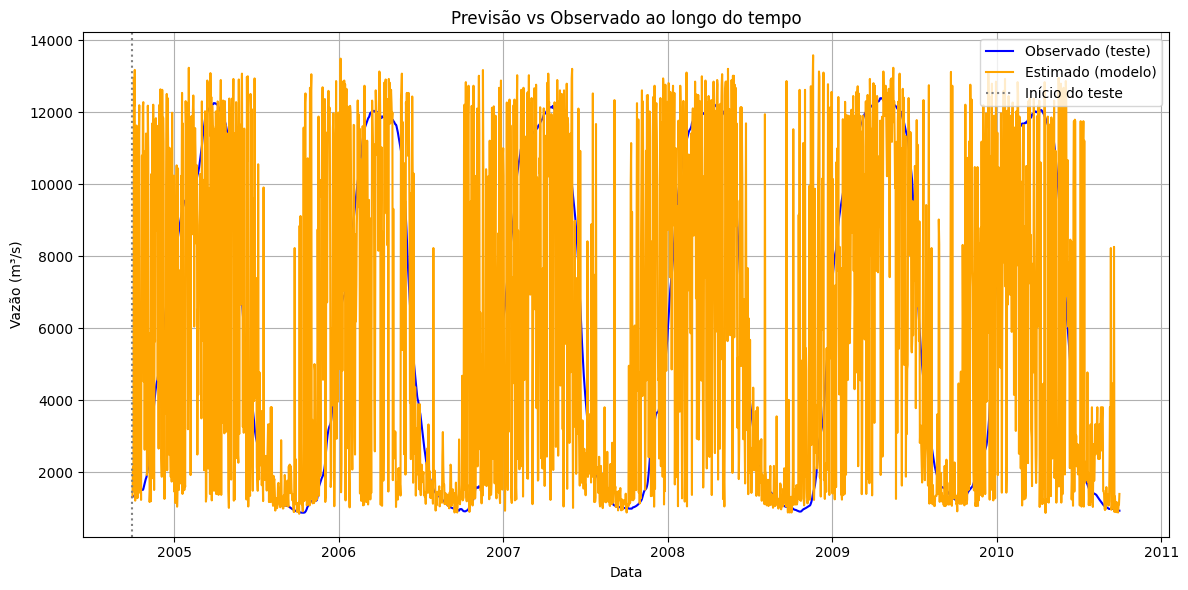

In [ ]:
# Treinar
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Prever
y_pred_dt = dt_model.predict(X_test)
teste['q_pred'] = y_pred_dt #Adicionando ao dataframe de teste

# Avaliar
rmse_dt = 100 * np.sqrt(mean_squared_error(y_test, y_pred_dt)) / np.mean(y_test)
r2_dt = r2_score(y_test, y_pred_dt)

print(f'Decision Tree - RMSE: {rmse_dt:.2f} % , R²: {r2_dt:.2f}')

# Plotando
plt.figure(figsize=(12, 6))
#plt.plot(bacia_df['date'], bacia_df['q'], label='Observado (completo)', color='lightgray')
plt.plot(teste['date'], teste['q'], label='Observado (teste)', color='blue')
plt.plot(teste['date'], teste['q_pred'], label='Estimado (modelo)', color='orange')
plt.axvline(bacia_df['date'].iloc[tamanho_treino], color='gray', linestyle=':', label='Início do teste')
plt.xlabel('Data')
plt.ylabel('Vazão (m³/s)')
plt.title('Previsão vs Observado ao longo do tempo')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

###Random Forest

RMSE: 53.6 %
R²: 0.44


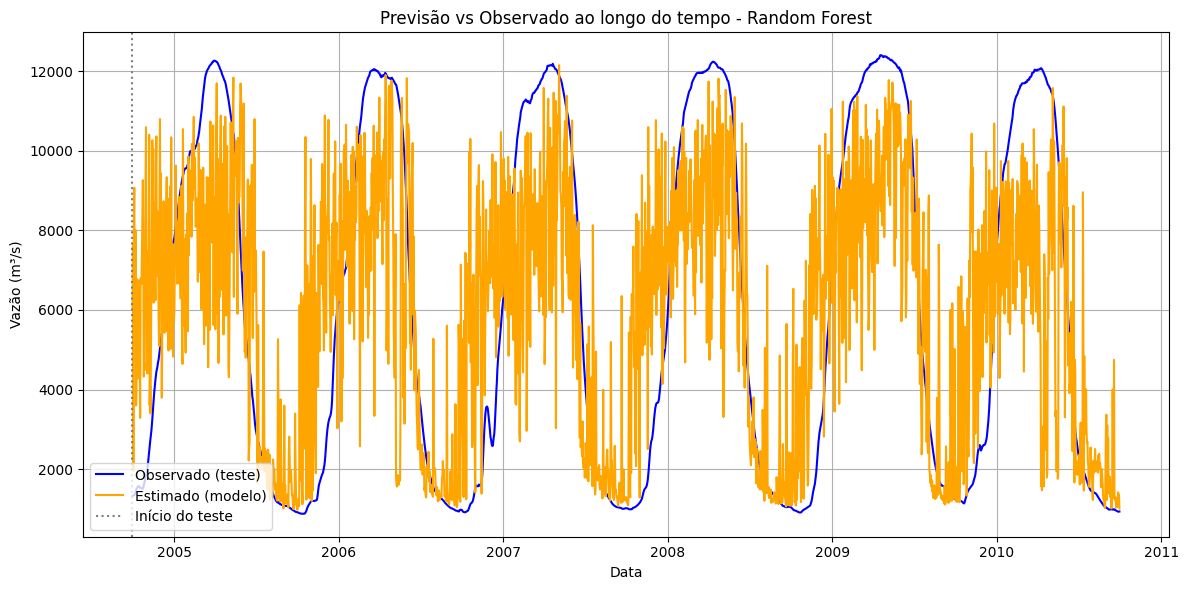

In [ ]:
# Treinar um modelo Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42) #n_estimator refere-se ao número de árvores na floresta aleatória
model.fit(X_train, y_train)

# Fazer previsões
y_pred = model.predict(X_test)
teste['q_pred'] = y_pred #Adicionando ao dataframe de teste

# Avaliar o modelo
rmse = 100 * np.sqrt(mean_squared_error(y_test, y_pred))/np.mean(y_test)
r2 = r2_score(y_test, y_pred)

# Exibir resultados
print(f'Random Forest - RMSE: {rmse:.1f} %, R²: {r2:.2f}')

# Plotando
plt.figure(figsize=(12, 6))
#plt.plot(bacia_df['date'], bacia_df['q'], label='Observado (completo)', color='lightgray')
plt.plot(teste['date'], teste['q'], label='Observado (teste)', color='blue')
plt.plot(teste['date'], teste['q_pred'], label='Estimado (modelo)', color='orange')
plt.axvline(bacia_df['date'].iloc[tamanho_treino], color='gray', linestyle=':', label='Início do teste')
plt.xlabel('Data')
plt.ylabel('Vazão (m³/s)')
plt.title('Previsão vs Observado ao longo do tempo - Random Forest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

###XGBoost

XGBoost - RMSE: 54.72 % , R²: 0.42


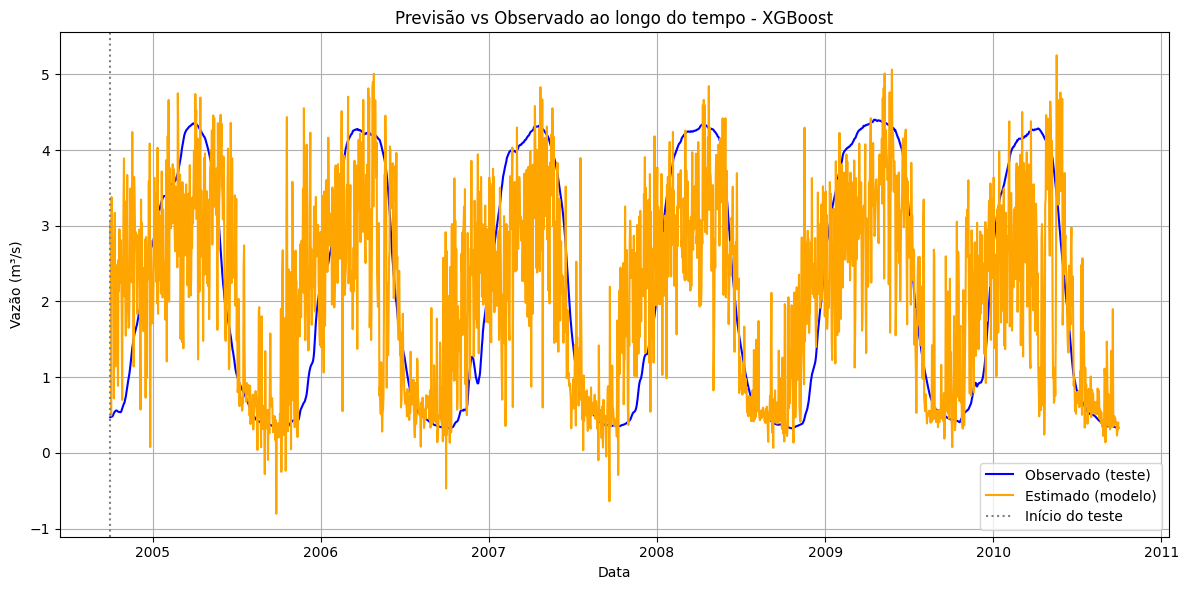

In [ ]:
# Treinar
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Prever
y_pred_xgb = xgb_model.predict(X_test)
teste['q_pred'] = y_pred_xgb #adicionando ao dataframe do teste

# Avaliar
rmse_xgb = 100 * np.sqrt(mean_squared_error(y_test, y_pred_xgb)) / np.mean(y_test)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f'XGBoost - RMSE: {rmse_xgb:.2f} % , R²: {r2_xgb:.2f}')

# Plotando
plt.figure(figsize=(12, 6))
#plt.plot(bacia_df['date'], bacia_df['q'], label='Observado (completo)', color='lightgray')
plt.plot(teste['date'], teste['q'], label='Observado (teste)', color='blue')
plt.plot(teste['date'], teste['q_pred'], label='Estimado (modelo)', color='orange')
plt.axvline(bacia_df['date'].iloc[tamanho_treino], color='gray', linestyle=':', label='Início do teste')
plt.xlabel('Data')
plt.ylabel('Vazão (m³/s)')
plt.title('Previsão vs Observado ao longo do tempo - XGBoost')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

###Neural Networks

MLP Neural Network - RMSE: 53.32 % , R²: 0.45


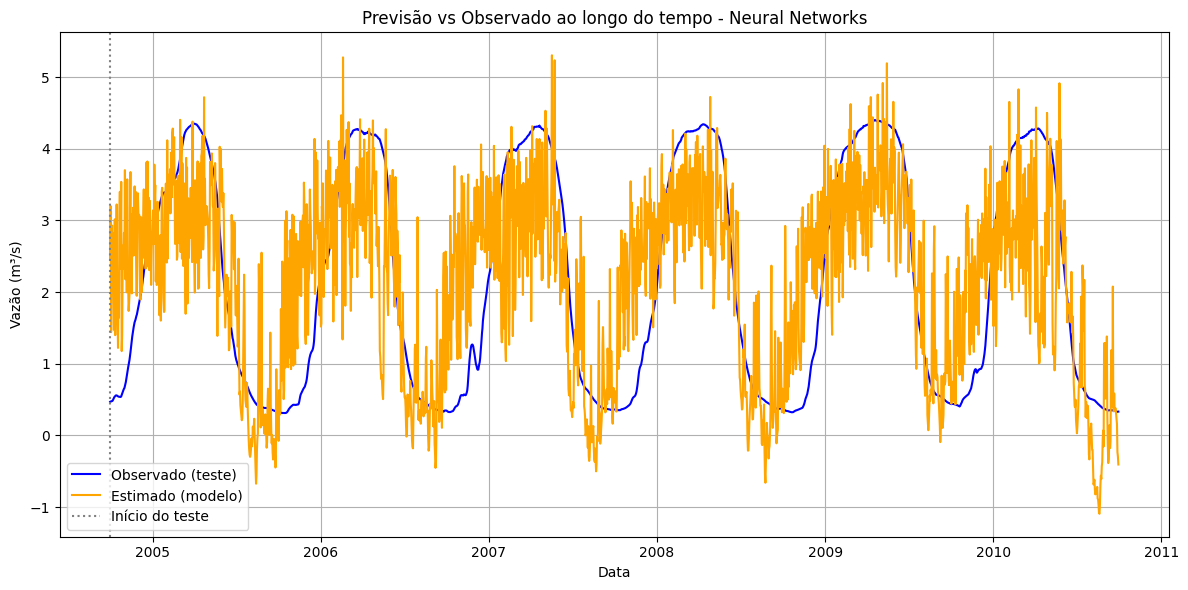

In [ ]:
# Treinar
mlp_model = MLPRegressor(hidden_layer_sizes=(100,100), max_iter=1000, random_state=42)
mlp_model.fit(X_train, y_train)

# Prever
y_pred_mlp = mlp_model.predict(X_test)
teste['q_pred'] = y_pred_mlp #Adicionando ao dataframe do teste

# Avaliar
rmse_mlp = 100 * np.sqrt(mean_squared_error(y_test, y_pred_mlp)) / np.mean(y_test)
r2_mlp = r2_score(y_test, y_pred_mlp)

print(f'MLP Neural Network - RMSE: {rmse_mlp:.2f} % , R²: {r2_mlp:.2f}')

# Plotando
plt.figure(figsize=(12, 6))
#plt.plot(bacia_df['date'], bacia_df['q'], label='Observado (completo)', color='lightgray')
plt.plot(teste['date'], teste['q'], label='Observado (teste)', color='blue')
plt.plot(teste['date'], teste['q_pred'], label='Estimado (modelo)', color='orange')
plt.axvline(bacia_df['date'].iloc[tamanho_treino], color='gray', linestyle=':', label='Início do teste')
plt.xlabel('Data')
plt.ylabel('Vazão (m³/s)')
plt.title('Previsão vs Observado ao longo do tempo - Neural Networks')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
results = pd.DataFrame({
    'Modelo': ['Decision Tree', 'Random Forest', 'XGBoost', 'MLP Neural Network'],
    'RMSE (%)': [rmse_dt, rmse, rmse_xgb, rmse_mlp],
    'R²': [r2_dt, r2, r2_xgb, r2_mlp]
})

print(results)

               Modelo   RMSE (%)        R²
0       Decision Tree  75.450811 -0.104122
1       Random Forest  53.496130  0.444948
2             XGBoost  54.717382  0.419316
3  MLP Neural Network  53.324834  0.448497
